### Description

The main purpose of this is to visualize the data but include the total charge in the size of each point, as Kaggle visualization and other neutrino detection papers discuss. That is, for each sensor (DOM) we see how many times in a given input event it was pinged, add the charges of each ping, and that total charge is the size of the pulse for that sensor. We then color the pulse by the first time that DOM was pinged. 

Fun-looking event IDs: 79, 131158, 917609

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:
# Uncomment to toggle interactivity of matplotlib plots
%matplotlib notebook

In [102]:
# Load data
batch1 = pd.read_parquet('../batches_train/batch_1_repartitions/part.0.parquet')
sensor_geom = pd.read_csv('../sensor_geometry.csv')
event_ids = list(set(batch1.index))

In [11]:
# Make a function that outputs (x,y,z) for a sensor_id input
def id_to_xyz(sen):
    row = tuple(sensor_geom.loc[sen][1:4])
    return row

In [167]:
def event_plot(eventid, 
               aux_incl=False, 
               show_sensors=True):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    event = batch1.loc[eventid]
    
    # Aux false or both?
    if aux_incl==False:
        event = event[event.auxiliary==False]
    else:
        pass
    
    # Each sensor will register one point; total charge (sum over all 
    # times that sensor registered a charge) corresponds to size in plot
    sensors_and_charge = event.groupby('sensor_id').sum()['charge']
    sensors = np.array(sensors_and_charge.index)
    
    # Cartesian coords of sensors to plot
    xs = [id_to_xyz(s)[0] for s in sensors]
    ys = [id_to_xyz(s)[1] for s in sensors]
    zs = [id_to_xyz(s)[2] for s in sensors]
    
    # Sizes computed from values in sensors_and_charge 
    sizes = sensors_and_charge.values
    
    # Times are computed by first time sensor registered a pulse
    times = [event[event.sensor_id==s].time.values[0] for s in sensors]

    # This scatter plots the sensor pulses
    im = ax.scatter(xs, ys, zs,
                    c=times,
                    cmap='rainbow_r',
                    s=10*sizes,
                    zorder=2,
                    label='pulse',
                    alpha=1)
    
    # This plots the sensors
    if show_sensors==True:
        ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
                   c='0.1',
                   alpha=0.03,
                   s=0.5,
                   zorder=1)

    # Color bar, legend, other niceties
    plt.colorbar(im,
                 orientation='vertical', 
                 label='Nanoseconds passed in event',
                 location='left',
                 fraction=0.02, 
                 pad=0.1)
    
    plt.title("Neutrino event " + str(eventid) + ", aux = " + str(aux_incl),
              fontsize=12)
    plt.legend(loc=(-0.3,0.9))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    ax.view_init(30,-45)
    
    ax.grid(False)

    plt.show()

<IPython.core.display.Javascript object>


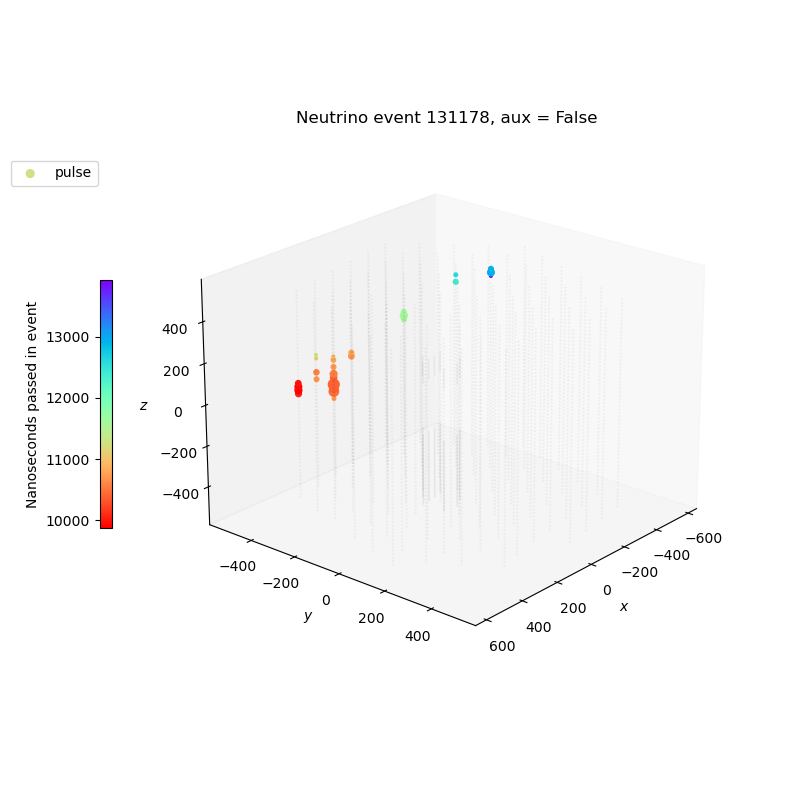

In [176]:
event_plot(event_ids[62], aux_incl=False)